In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d kevinarvai/clinvar-conflicting




Dataset URL: https://www.kaggle.com/datasets/kevinarvai/clinvar-conflicting
License(s): CC0-1.0


In [ ]:
!unzip clinvar-conflicting.zip


Archive:  clinvar-conflicting.zip
  inflating: clinvar_conflicting.csv  


**Load and Preprocess the Dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style(style='whitegrid')
sns.set(font_scale=1.5);



In [ ]:
df = pd.read_csv('/content/clinvar_conflicting.csv', dtype={0: object, 38: str, 40: object})

In [ ]:

df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


In [ ]:
df['CLASS'].value_counts()

,count
CLASS,
0,48754
1,16434


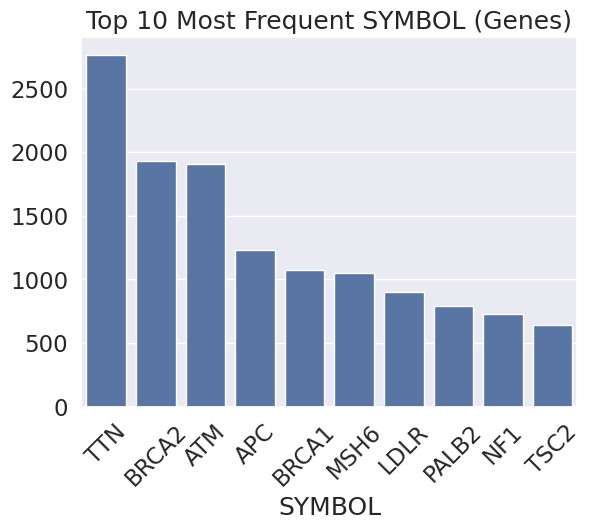

In [ ]:
top_genes = df['SYMBOL'].value_counts().nlargest(10)
sns.barplot(x=top_genes.index, y=top_genes.values)
plt.title("Top 10 Most Frequent SYMBOL (Genes)")
plt.xticks(rotation=45)
plt.show()

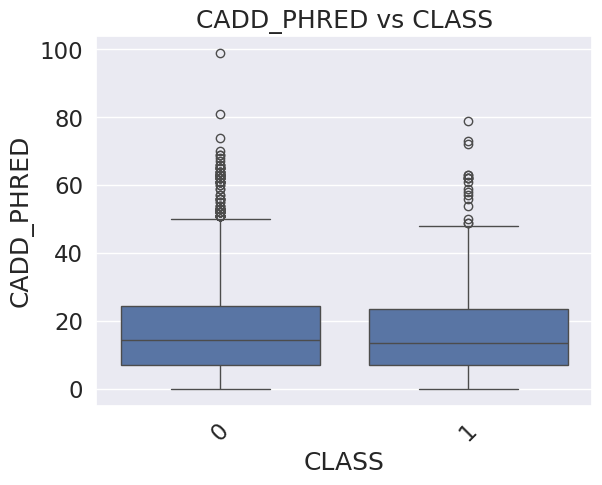

In [ ]:
sns.boxplot(x='CLASS', y='CADD_PHRED', data=df)
plt.title("CADD_PHRED vs CLASS")
plt.xticks(rotation=45)
plt.show()

In [ ]:

gene_ct = pd.crosstab(df.SYMBOL, df.CLASS, margins=True)

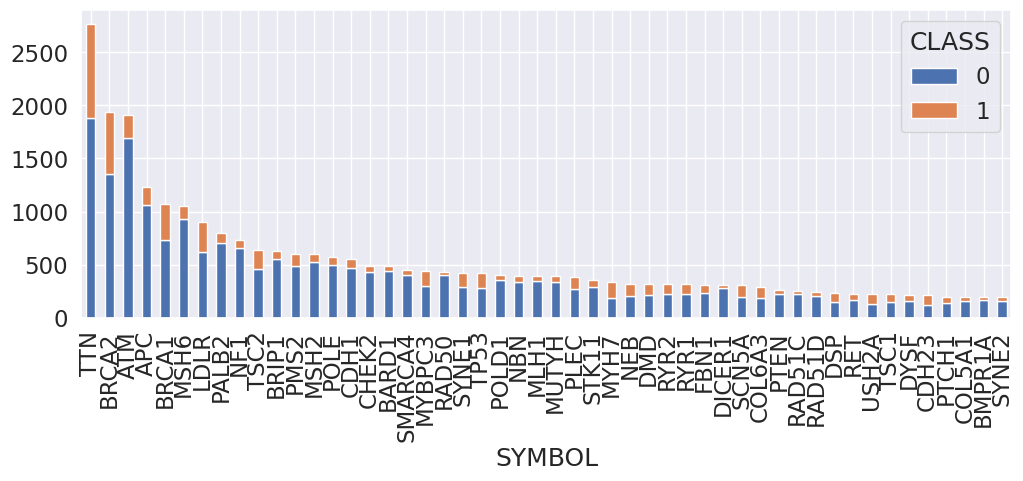

In [ ]:

gene_ct = pd.crosstab(df.SYMBOL, df.CLASS, margins=True)
gene_ct.drop('All', axis=0, inplace=True)

# limit to the 50 most submitted genes for visualization
gene_ct = gene_ct.sort_values(by='All', ascending=False).head(50)
gene_ct.drop('All', axis=1, inplace=True)

gene_ct.plot.bar(stacked=True, figsize=(12, 4));

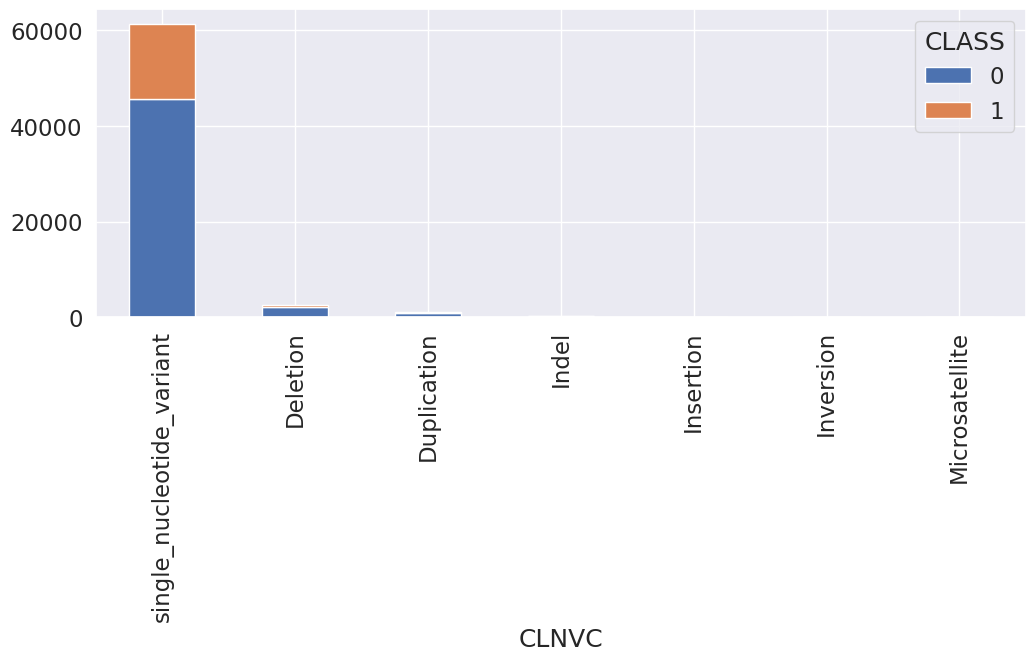

In [ ]:

vt_ct = pd.crosstab(df.CLNVC, df.CLASS, margins=True)
vt_ct.drop('All', axis=0, inplace=True)

# limit to the 50 most submitted genes for visualization
vt_ct = vt_ct.sort_values(by='All', ascending=False)
vt_ct.drop('All', axis=1, inplace=True)

vt_ct.plot.bar(stacked=True, figsize=(12, 4));

In [ ]:
MC_list = df.MC.dropna().str.split(',').apply(lambda row: list((c.split('|')[1] for c in row)))
MC_encoded = pd.get_dummies(MC_list.apply(pd.Series).stack()).groupby(level=0).sum() # Changed this line to use groupby and sum
MC_encoded = MC_encoded.reindex(index=MC_list.index)

# Incorporate the transformed MC feature into the existing DataFrame
df = df.join(MC_encoded).drop(columns=['MC'])

# Transformed MC feature
MC_encoded.head()

,2KB_upstream_variant,3_prime_UTR_variant,500B_downstream_variant,5_prime_UTR_variant,frameshift_variant,intron_variant,missense_variant,nonsense,splice_acceptor_variant,splice_donor_variant,synonymous_variant
0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
mccounts= {0: {},
           1: {},
           'All': {}
          }

for col in MC_encoded.columns:
    for class_ in [0, 1]:
        mccounts[class_][col] = df.loc[df['CLASS'] == class_][col].sum()

    mccounts['All'][col] = df[col].sum()

mc_ct = pd.DataFrame.from_dict(mccounts)

mc_ct_all = mc_ct.sum(axis=0)
mc_ct_all.name = 'All'
mc_ct = pd.concat([mc_ct, mc_ct_all.to_frame().T], ignore_index=False) # Use concat to append the row


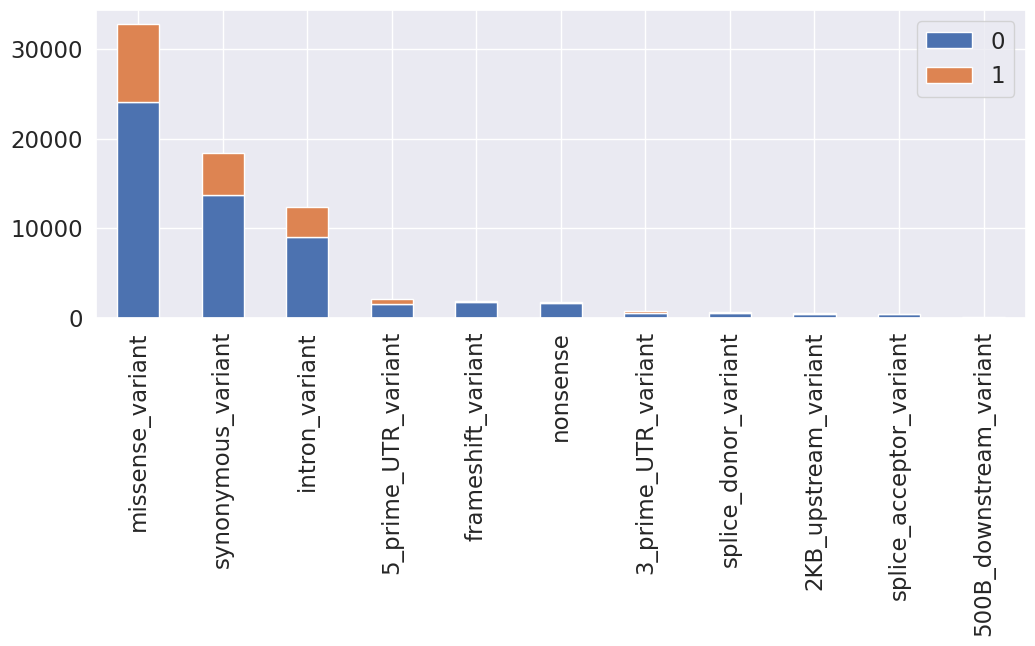

In [ ]:
mc_ct.drop('All', axis=0, inplace=True)

mc_ct = mc_ct.sort_values(by='All', ascending=False)
mc_ct.drop('All', axis=1, inplace=True)

mc_ct.plot.bar(stacked=True, figsize=(12, 4));

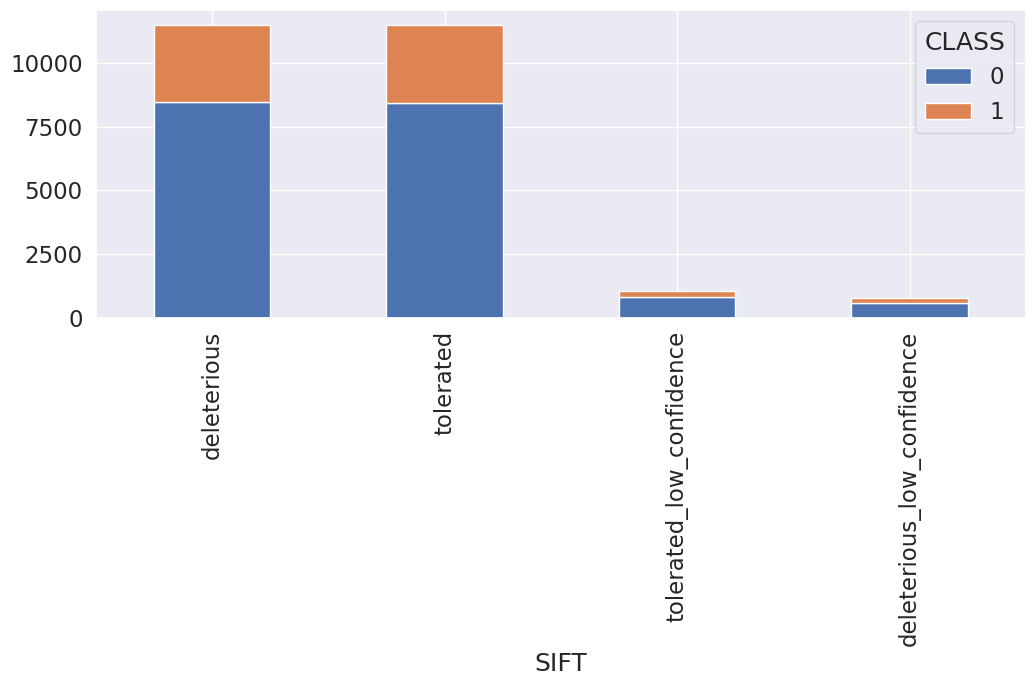

In [ ]:

sift_ct = pd.crosstab(df.SIFT, df.CLASS, margins=True)
sift_ct.drop('All', axis=0, inplace=True)

# limit to the 50 most submitted genes for visualization
sift_ct = sift_ct.sort_values(by='All', ascending=False)
sift_ct.drop('All', axis=1, inplace=True)

sift_ct.plot.bar(stacked=True, figsize=(12, 4));


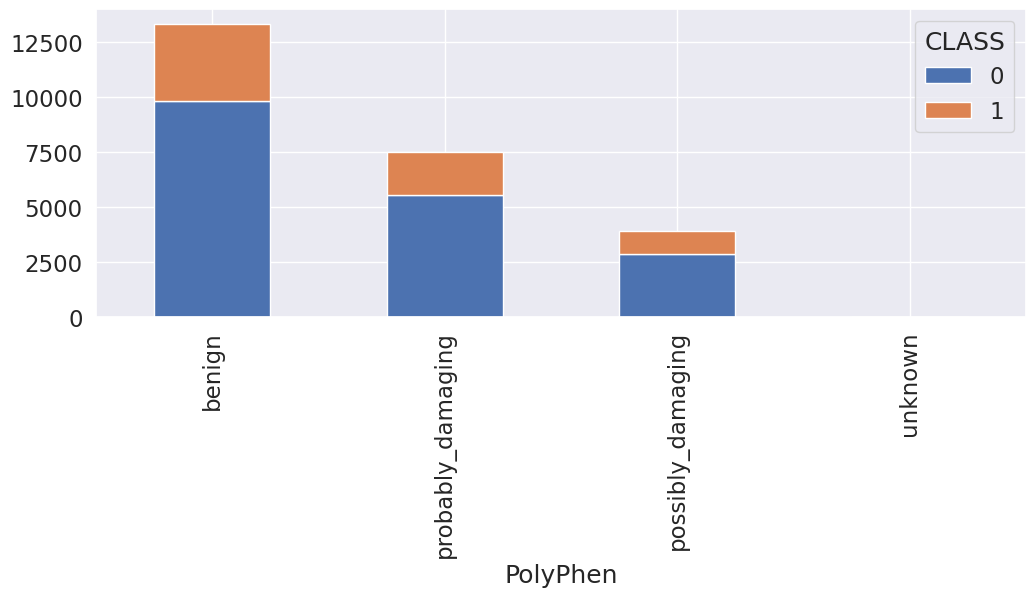

In [ ]:
pp_ct = pd.crosstab(df.PolyPhen, df.CLASS, margins=True)
pp_ct.drop('All', axis=0, inplace=True)

# limit to the 50 most submitted genes for visualization
pp_ct = pp_ct.sort_values(by='All', ascending=False)
pp_ct.drop('All', axis=1, inplace=True)

pp_ct.plot.bar(stacked=True, figsize=(12, 4));

In [ ]:

df = pd.get_dummies(df, columns=['SIFT', 'PolyPhen'])

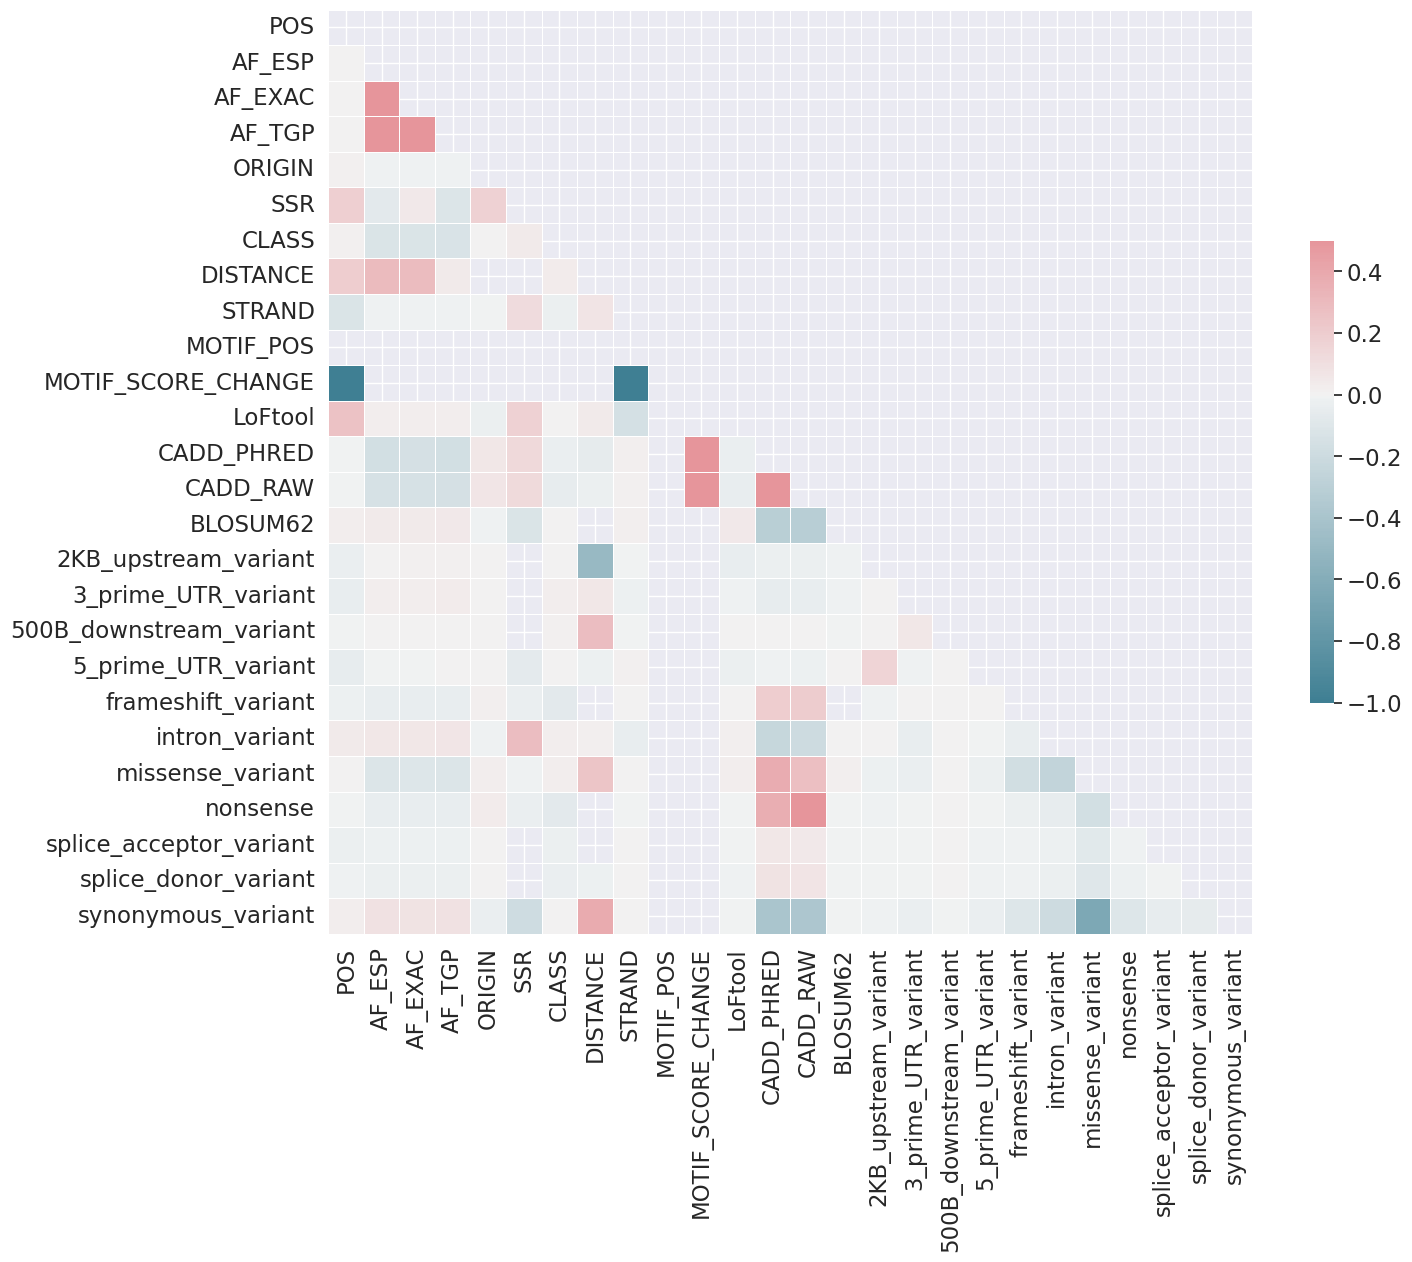

In [ ]:
# Select only numeric features for correlation analysis
numeric_df = df.select_dtypes(include=np.number)

# Calculate correlation matrix
corr = numeric_df.corr()


# Calculate correlation matrix
corr = numeric_df.corr()
import numpy as np
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True);

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5});

<ipython-input-20-616d0a2c3af1>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.AF_ESP, label="AF_ESP")
<ipython-input-20-616d0a2c3af1>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.AF_EXAC, label="AF_EXAC")
<ipython-input-20-616d0a2c3af1>:4: UserWarning: 

`distplot` is a deprecated f

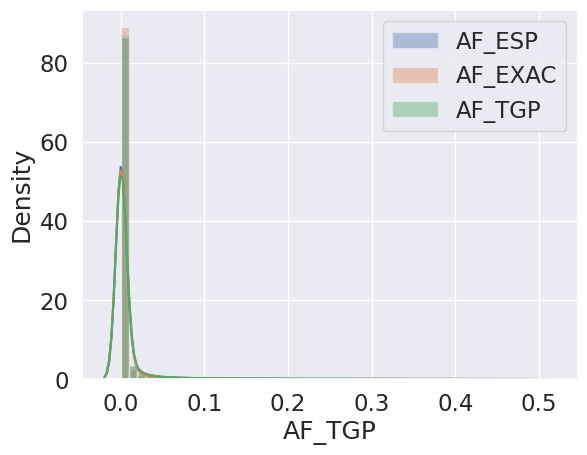

In [ ]:

# most values are low
sns.distplot(df.AF_ESP, label="AF_ESP")
sns.distplot(df.AF_EXAC, label="AF_EXAC")
sns.distplot(df.AF_TGP, label="AF_TGP")
plt.legend();

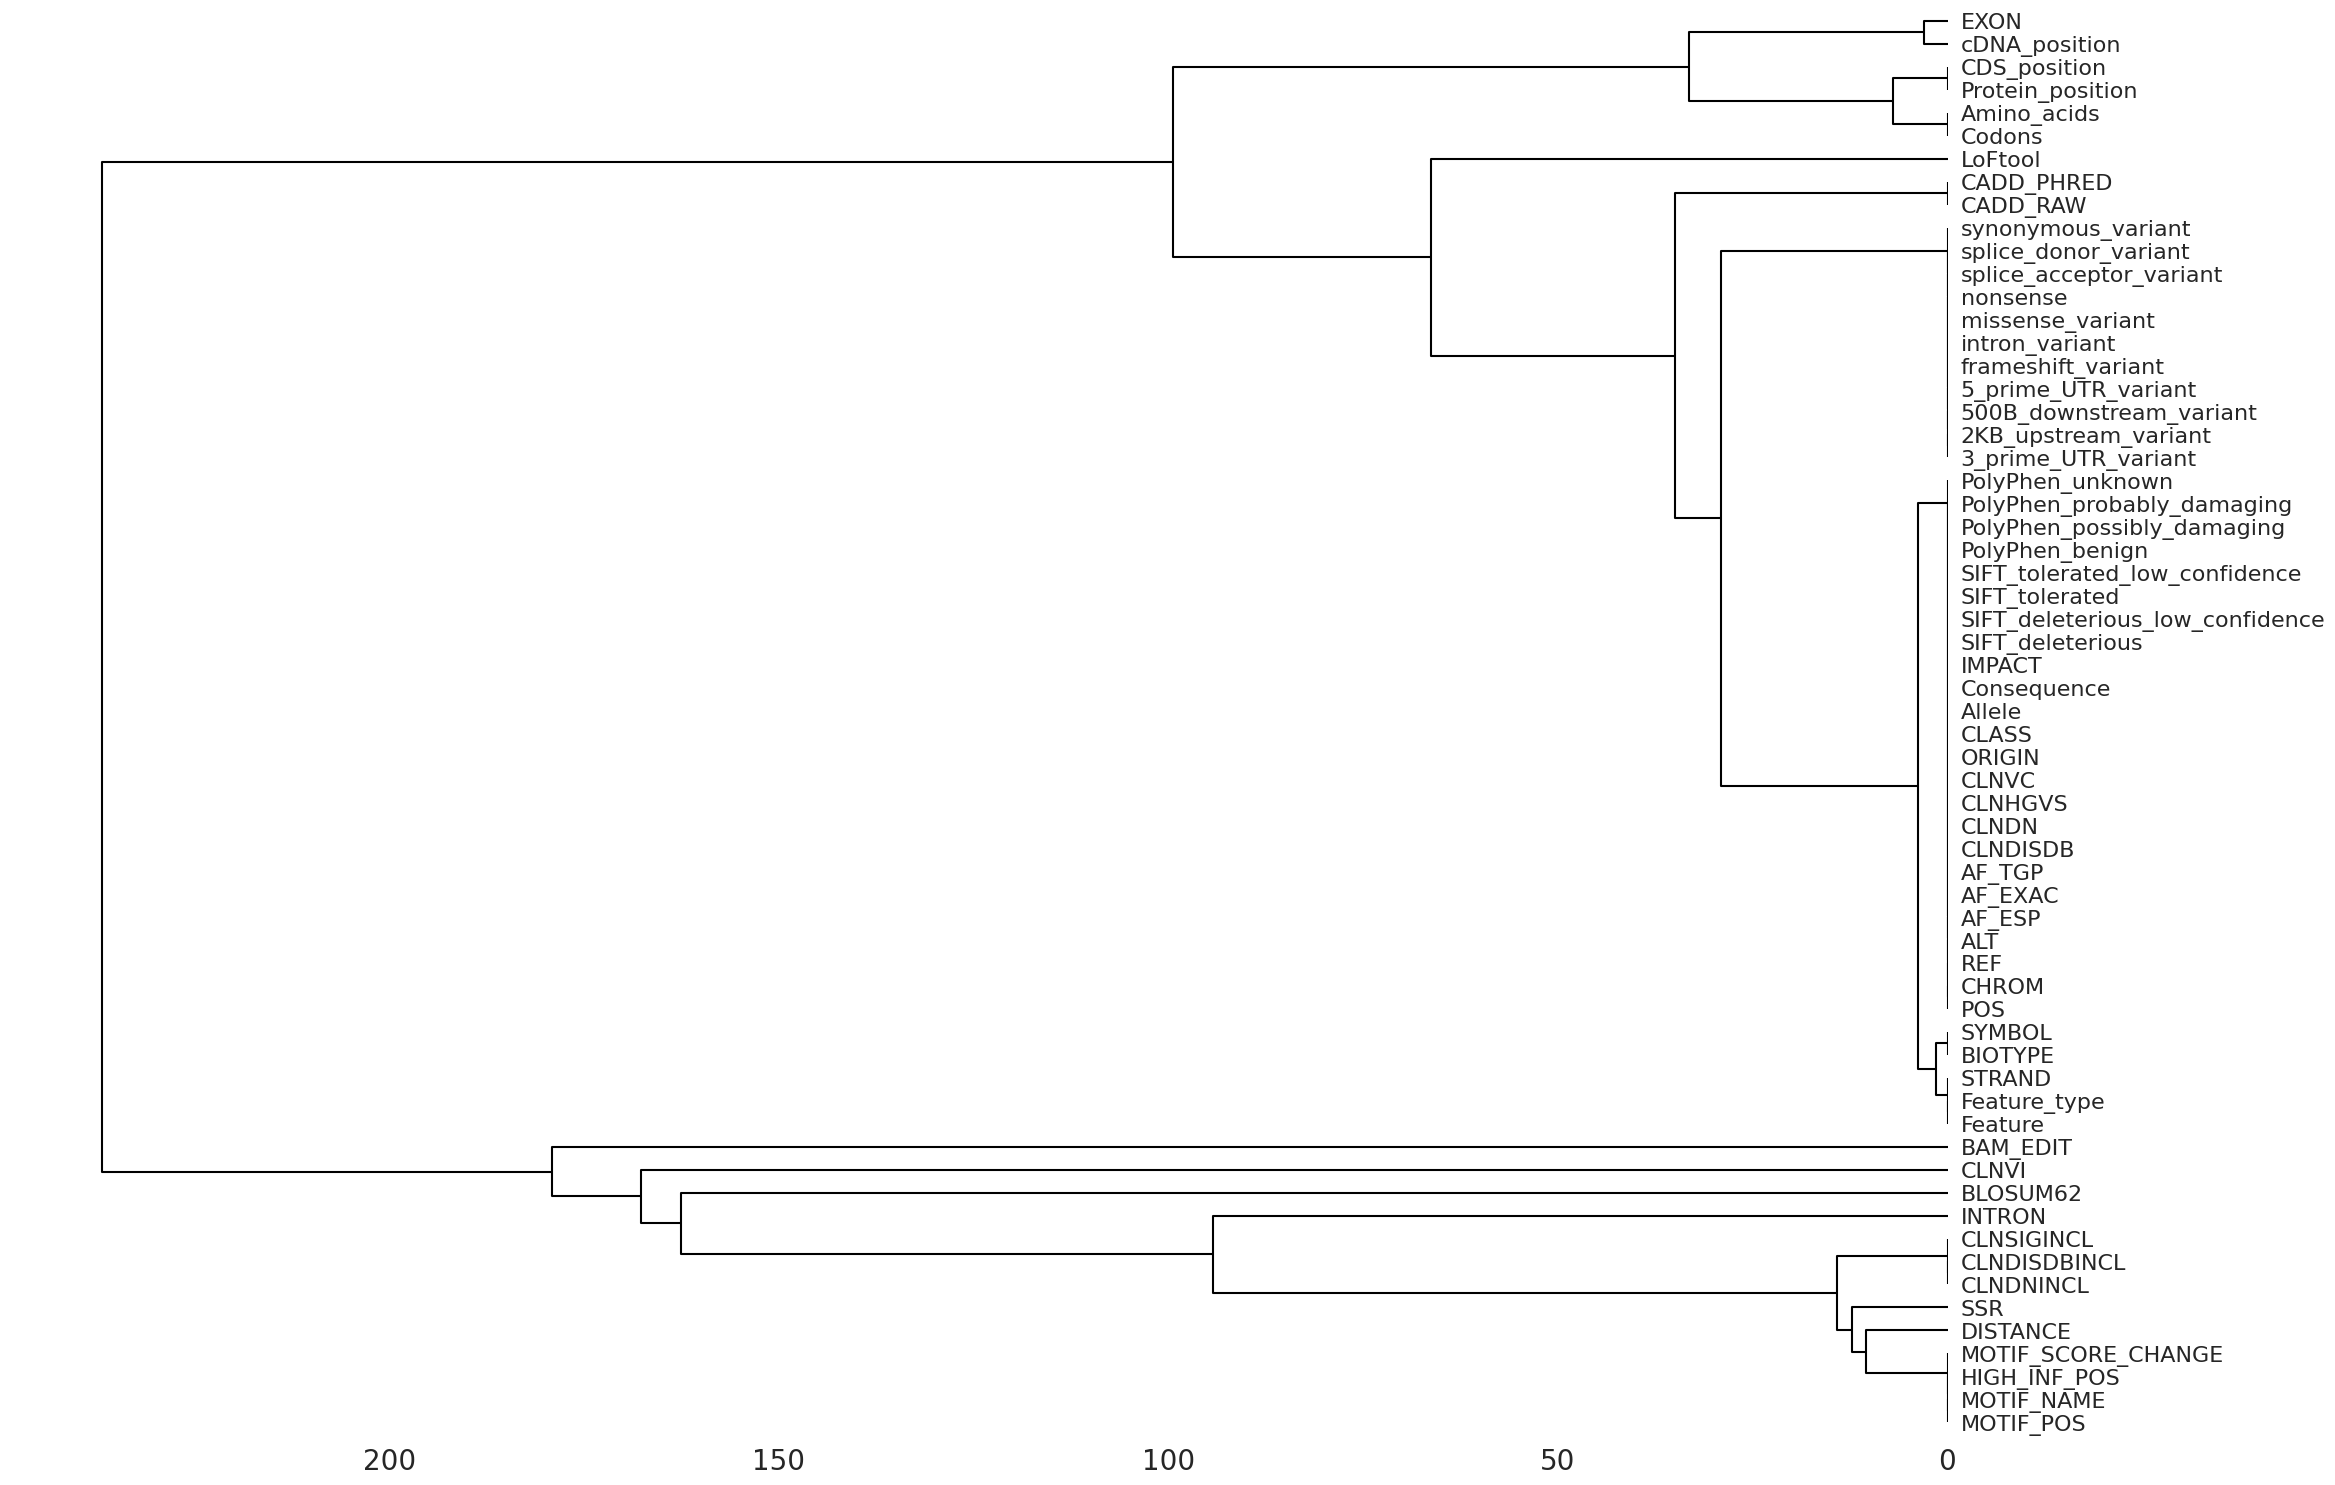

In [ ]:
import missingno as msno
msno.dendrogram(df);


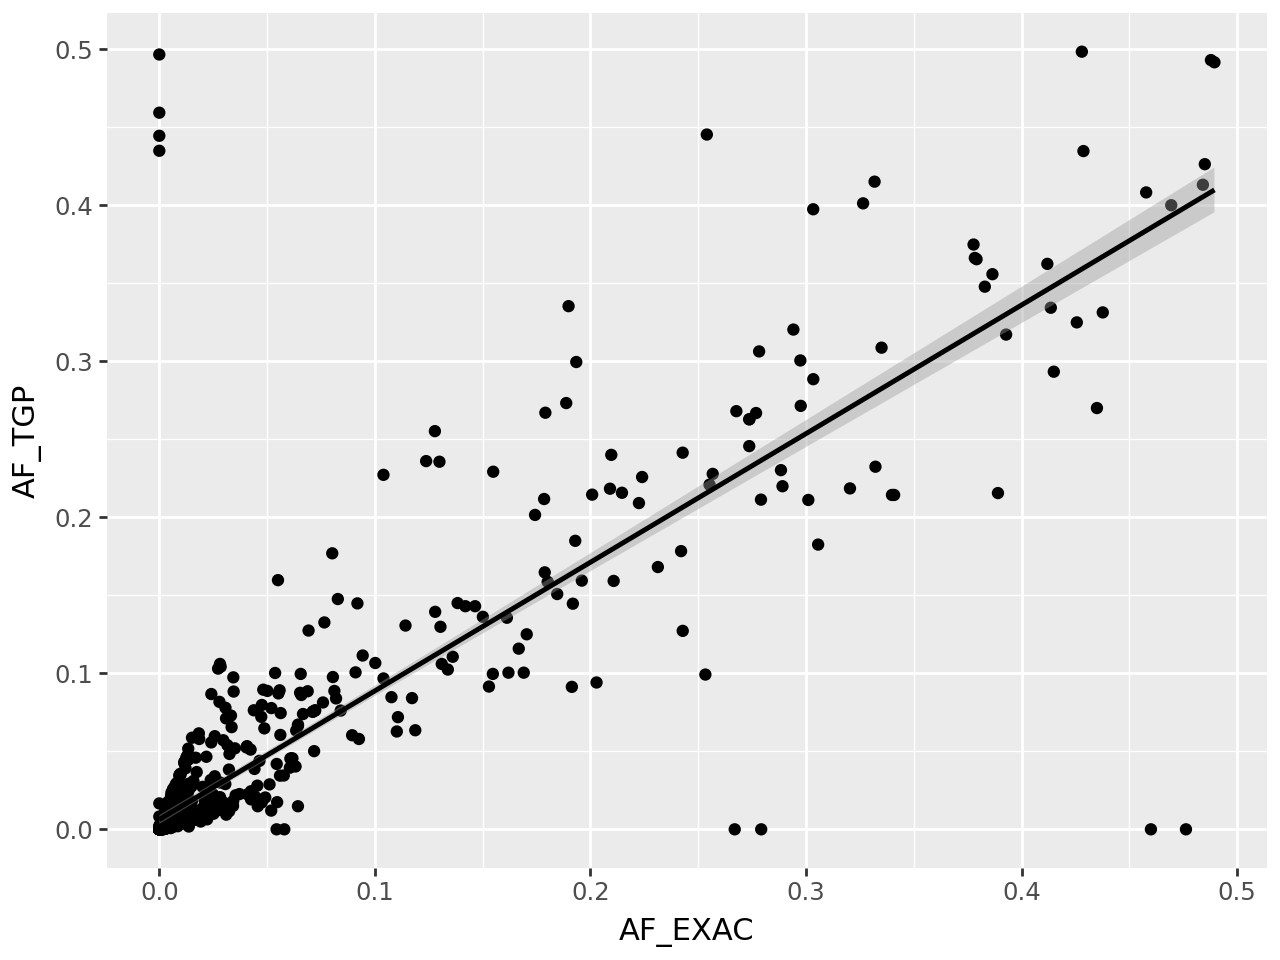

In [ ]:
from plotnine import *
GD=df.head(1000)

(
    ggplot(GD)
        + aes('AF_EXAC', 'AF_TGP')
        + geom_point()
        + stat_smooth()
)

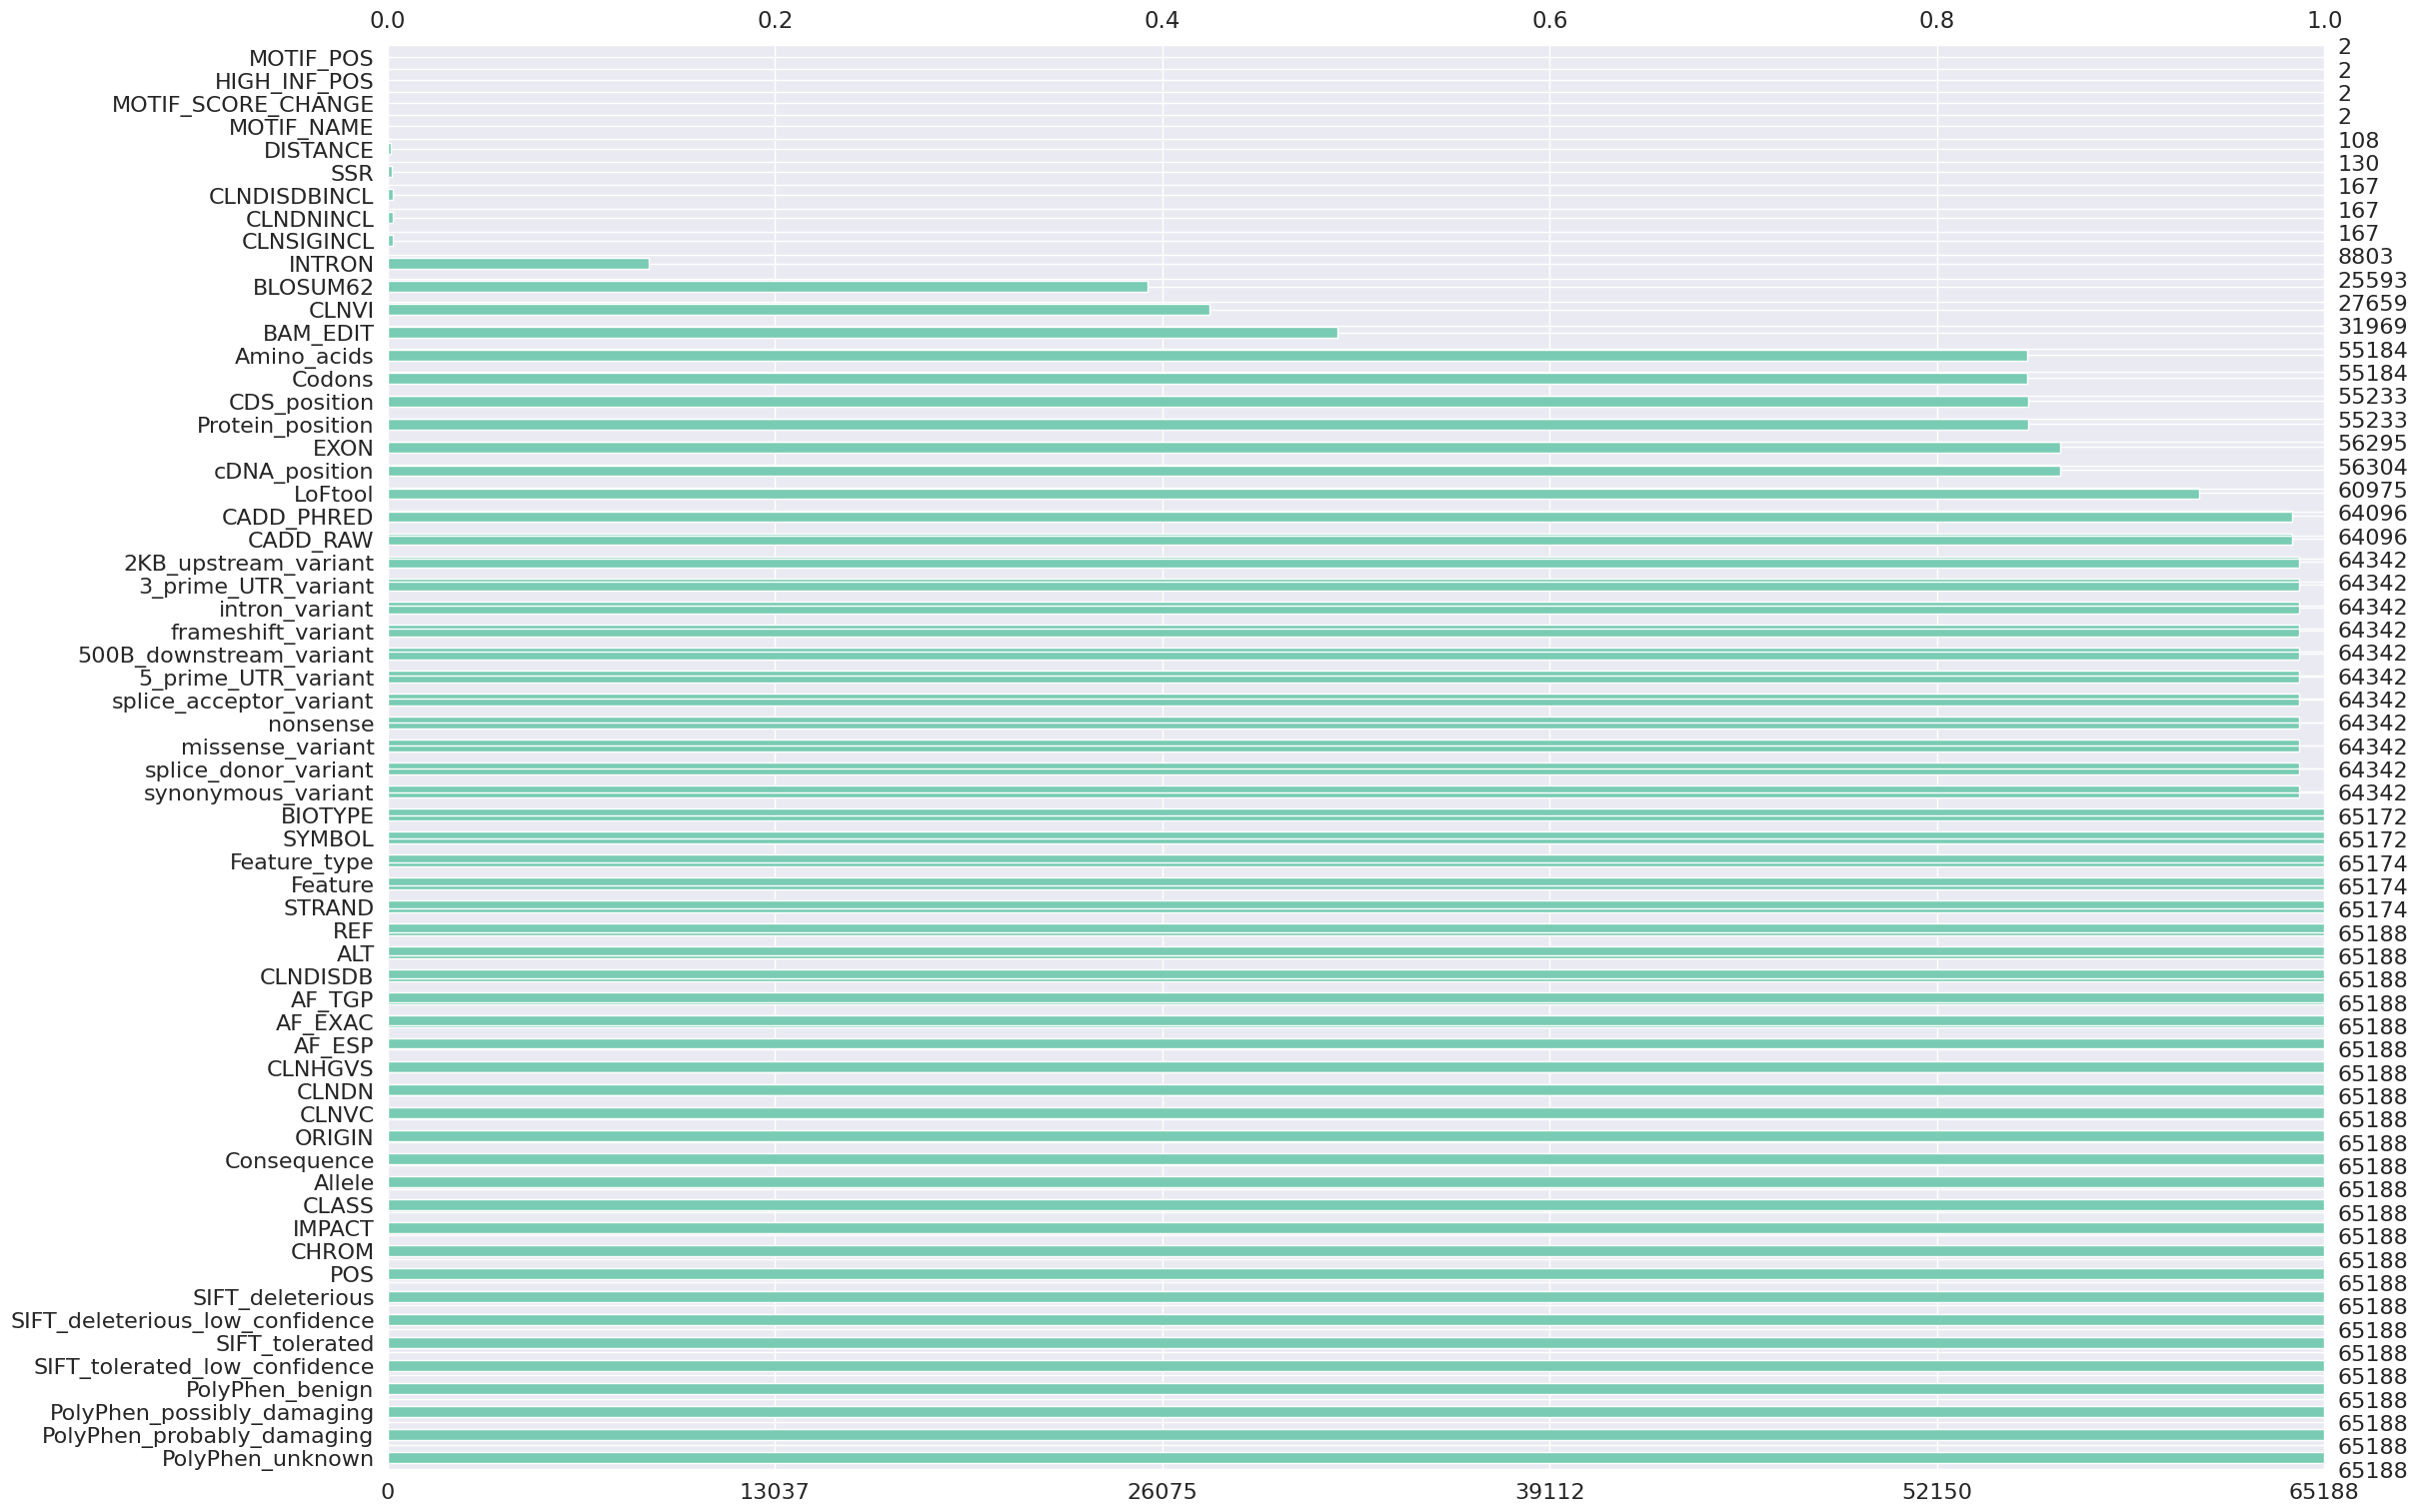

In [ ]:
msno.bar(df,color='#79ccb3',sort='descending')
plt.show()

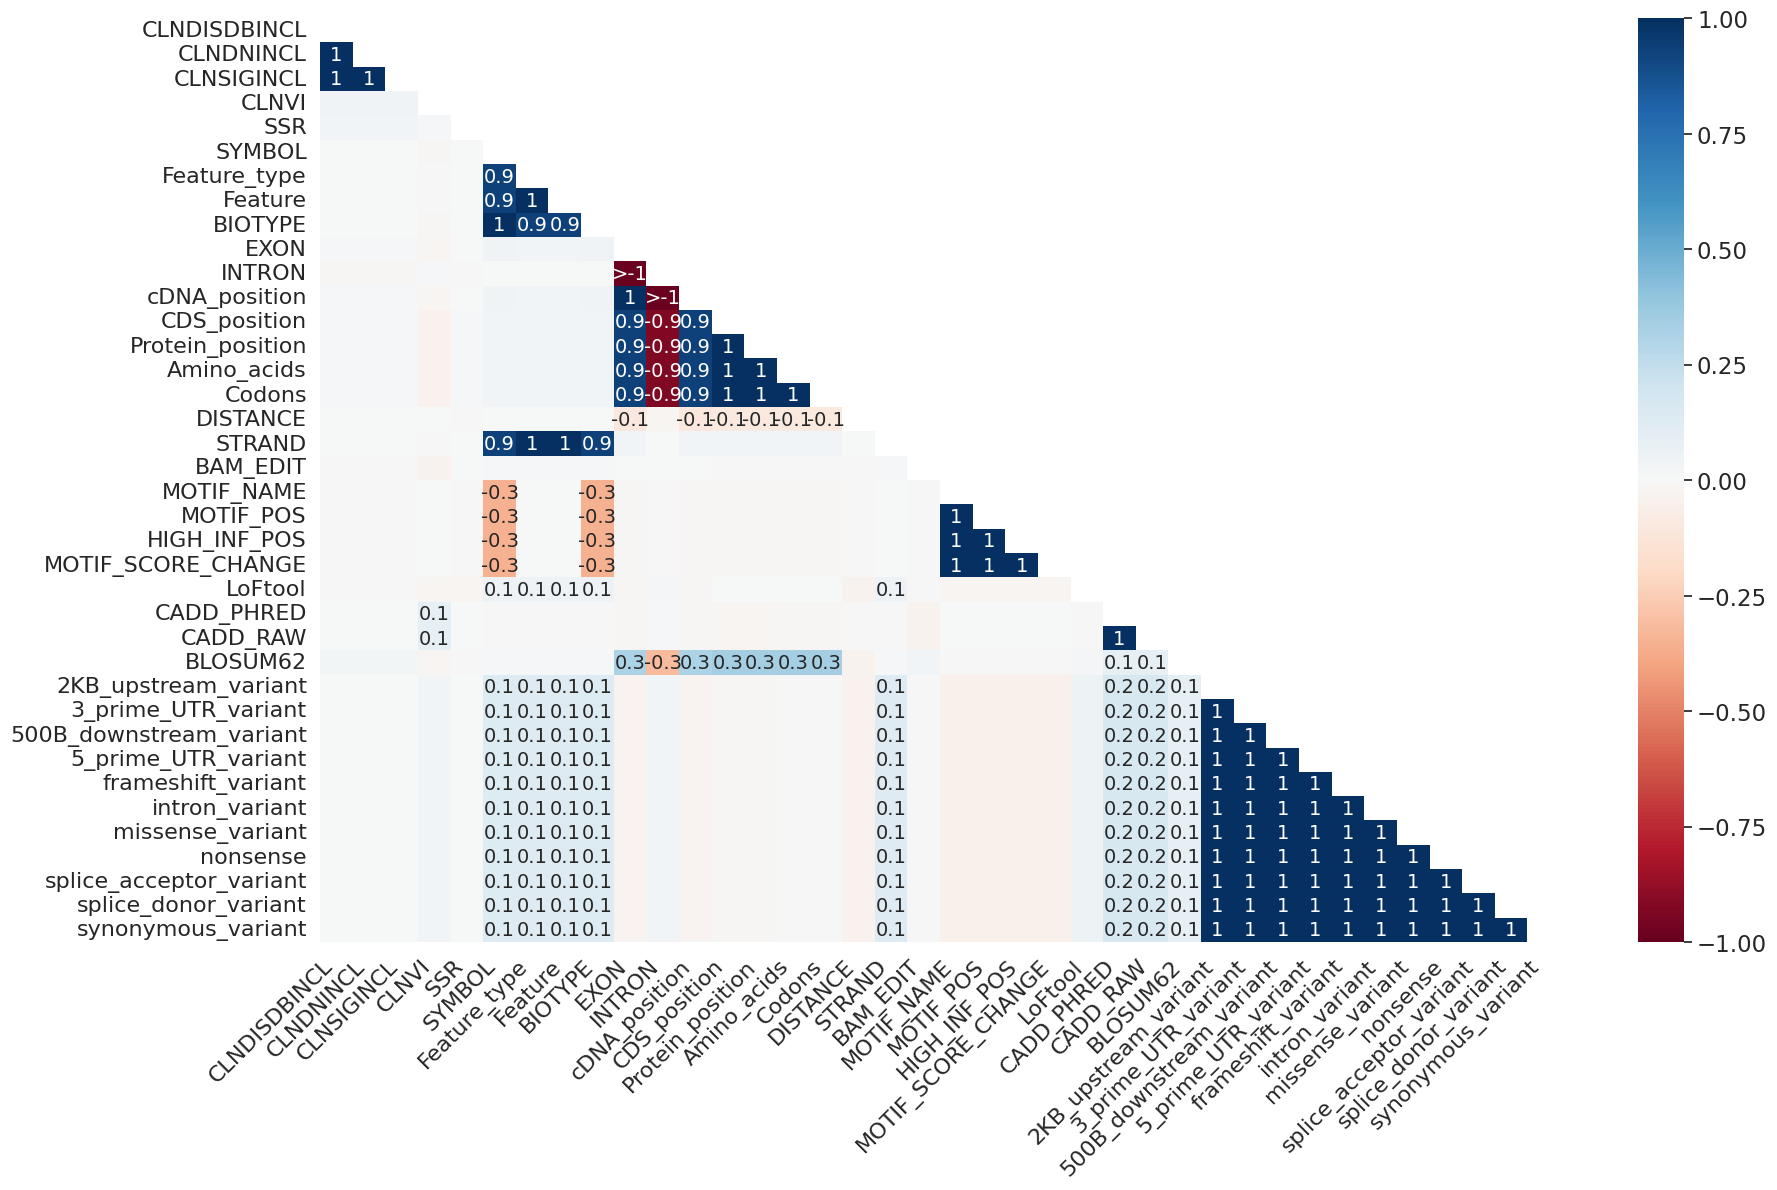

In [ ]:
msno.heatmap(df)
plt.show()

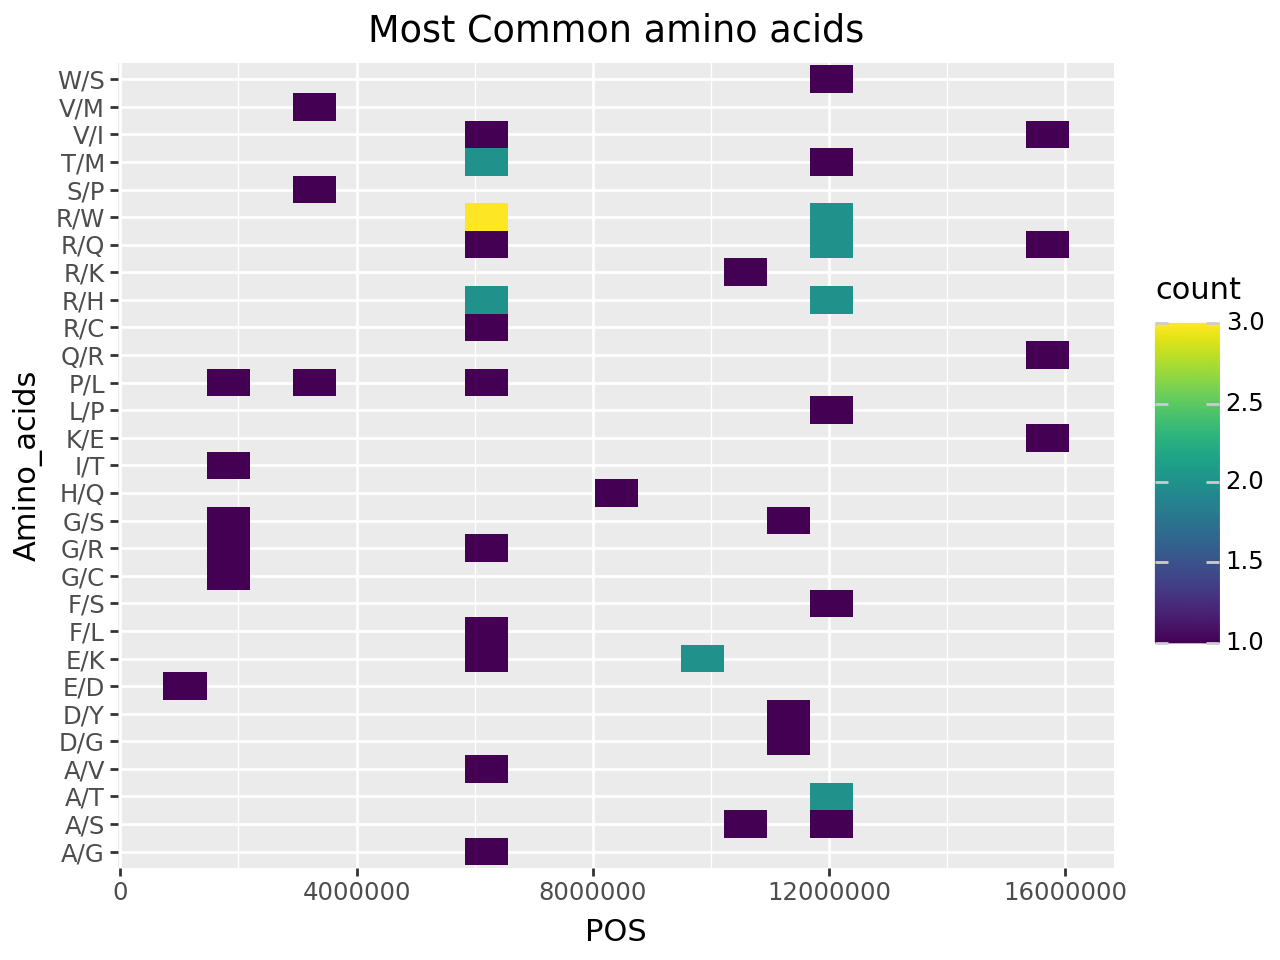

In [ ]:
from plotnine import *

(ggplot(df.head(50))
         + aes('POS', 'Amino_acids')
         + geom_bin2d(bins=20)
         + ggtitle("Most Common amino acids")
)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, mean_squared_error, mean_absolute_error
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


In [ ]:
import pandas as pd

df = pd.read_csv("/content/clinvar_conflicting.csv")
print("Original shape:", df.shape)
print(df.columns)
df.head()


Original shape: (65188, 46)
Index(['CHROM', 'POS', 'REF', 'ALT', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'CLNDISDB',
       'CLNDISDBINCL', 'CLNDN', 'CLNDNINCL', 'CLNHGVS', 'CLNSIGINCL', 'CLNVC',
       'CLNVI', 'MC', 'ORIGIN', 'SSR', 'CLASS', 'Allele', 'Consequence',
       'IMPACT', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 'EXON',
       'INTRON', 'cDNA_position', 'CDS_position', 'Protein_position',
       'Amino_acids', 'Codons', 'DISTANCE', 'STRAND', 'BAM_EDIT', 'SIFT',
       'PolyPhen', 'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS',
       'MOTIF_SCORE_CHANGE', 'LoFtool', 'CADD_PHRED', 'CADD_RAW', 'BLOSUM62'],
      dtype='object')


<ipython-input-27-ab2b2fbf514b>:3: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.


,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


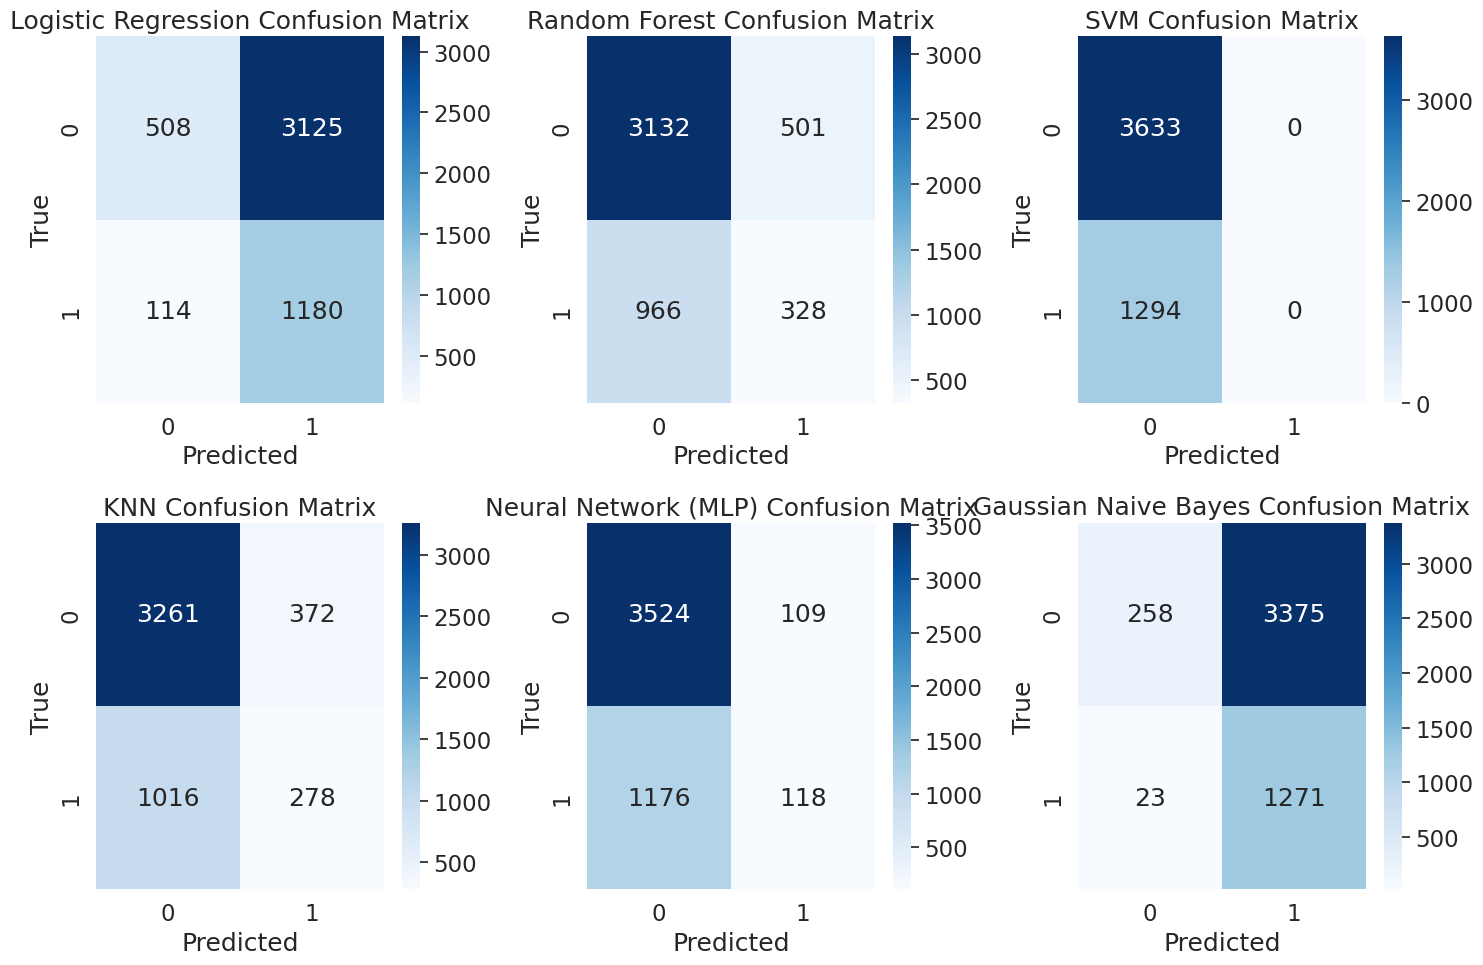

<Figure size 640x480 with 0 Axes>

                  Model  Accuracy  Precision    Recall  F1-score       MAE
0   Logistic Regression  0.342602   0.274100  0.911901  0.421504  0.657398
1         Random Forest  0.702253   0.395657  0.253478  0.308997  0.297747
2                   SVM  0.737366   0.000000  0.000000  0.000000  0.262634
3                   KNN  0.718287   0.427692  0.214838  0.286008  0.281713
4  Neural Network (MLP)  0.739192   0.519824  0.091190  0.155161  0.260808
5  Gaussian Naive Bayes  0.310331   0.273569  0.982226  0.427946  0.689669


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, mean_absolute_error, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Step 1: Load dataset
df = pd.read_csv("/content/clinvar_conflicting.csv")

# Step 2: Filter for binary classification
df = df[df['CLASS'].isin([0, 1])]
df['CLASS'] = df['CLASS'].astype(int)

# Step 3: Feature selection
features = ['CADD_PHRED', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'SIFT', 'PolyPhen']
features = [f for f in features if f in df.columns]
df_model = df[features + ['CLASS']]

# Step 4: Encode SIFT and PolyPhen manually
sift_map = {
    'tolerated': 0,
    'deleterious': 1,
    'deleterious_low_confidence': 0.5,
    'tolerated_low_confidence': 0.5
}
pp_map = {
    'benign': 0,
    'possibly_damaging': 0.5,
    'probably_damaging': 1
}
df_model['SIFT'] = df_model['SIFT'].map(sift_map)
df_model['PolyPhen'] = df_model['PolyPhen'].map(pp_map)

# Step 5: Drop rows with any missing values
df_model.dropna(inplace=True)

# Step 6: Define features and target
X = df_model.drop(columns=['CLASS'])
y = df_model['CLASS']


# Step 7: Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 8: Define classifiers (added Gaussian Naive Bayes)
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Neural Network (MLP)": MLPClassifier(max_iter=1000),
    "Gaussian Naive Bayes": GaussianNB()
}

# Step 9: Train and evaluate
results = []
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust if more classifiers added
axes = axes.flatten()

for i, (name, clf) in enumerate(classifiers.items()):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axes[i])
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, 'predict_proba') else np.zeros_like(y_pred)

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        # Changed 'Variant2' to 1 as pos_label should be one of the valid labels (0 or 1)
        'Precision': precision_score(y_test, y_pred, pos_label=1),
        'Recall': recall_score(y_test, y_pred, pos_label=1),
        'F1-score': f1_score(y_test, y_pred, pos_label=1),
        'MAE': mean_absolute_error(y_test, y_pred)
    })

plt.tight_layout()
plt.show()



plt.tight_layout()
plt.show()
# Step 10: Show the results
results_df = pd.DataFrame(results)
print(results_df)

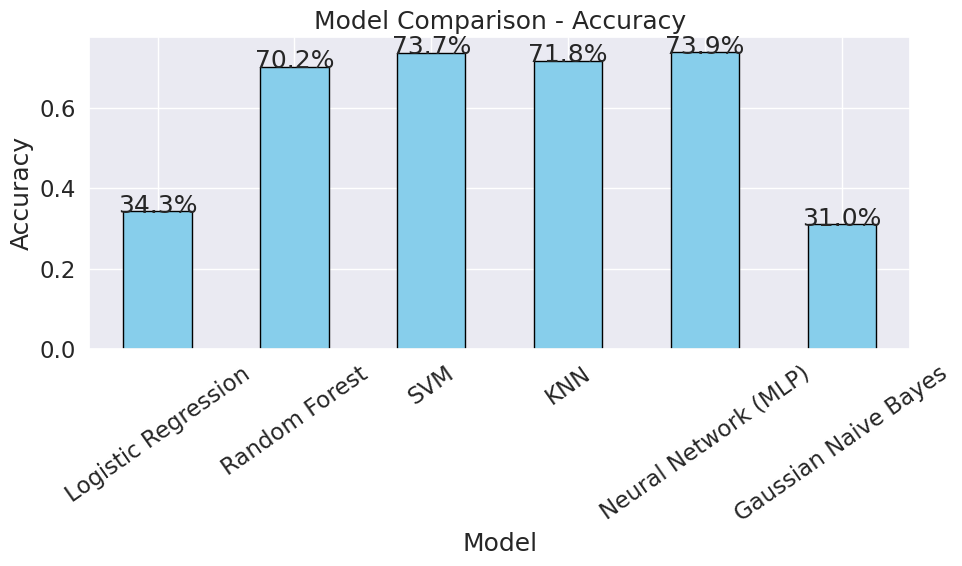

In [ ]:

# Plotting comparison of models based on Accuracy
plt.figure(figsize=(10, 6))
ax = results_df.set_index('Model')['Accuracy'].plot(kind='bar', color='skyblue', edgecolor='black')

# Title and labels
plt.title('Model Comparison - Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=35)

# Add accuracy percentage on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')

plt.tight_layout()
plt.show()

